In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

color = sns.color_palette()
%matplotlib inline

pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 200

In [4]:
path = '/home/vishy/Desktop/Kaggle/Avito/Data/'
training = pd.read_csv(path+'train.csv', index_col = "item_id", parse_dates = ["activation_date"], nrows=100000)
testing = pd.read_csv(path+'test.csv', index_col = "item_id", parse_dates = ["activation_date"], nrows=50000)
print(training.shape,testing.shape)

(100000, 17) (50000, 16)


In [9]:
training['imlen'] = len(training['image'].astype(str))

In [10]:
training.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability,imlen
item_id,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяца.цвет серый",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c7679f17c333c959b19,1008.0,0.12789,100000
2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d71427001e1e0859c0fb843a31,692.0,0.00000,100000
ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ray, USB. Если настроить, то работает смарт тв /\nТорг",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a8713f112c67e29bb42,3032.0,0.43177,100000
02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c841302bf49820803501b4b,796.0,0.80323,100000
7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2c089d8376e883ed33b,2264.0,0.20797,100000


In [8]:
from subprocess import check_output
print(check_output(["ls", path]).decode("utf8"))

periods_test.csv
periods_train.csv
test_active.csv
test.csv
test_jpg
train_active.csv
train.csv
train_jpg



# Description of the Different Data

The description of the data files from the data page:

train.csv - Train data.

test.csv - Test data. Same schema as the train data, minus deal_probability.

train_active.csv - Supplemental data from ads that were displayed during the same period as train.csv. Same schema as the train data, minus deal_probability.

test_active.csv - Supplemental data from ads that were displayed during the same period as test.csv. Same schema as the train data, minus deal_probability.

periods_train.csv - Supplemental data showing the dates when the ads from train_active.csv were activated and when they where displayed.

periods_test.csv - Supplemental data showing the dates when the ads from test_active.csv were activated and when they where displayed. Same schema as periods_train.csv, except that the item ids map to an ad in test_active.csv.

train_jpg.zip - Images from the ads in train.csv.

test_jpg.zip - Images from the ads in test.csv.

sample_submission.csv - A sample submission in the correct format.

In [7]:
training.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
item_id,,,,,,,,,,,,,,,,,
b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [33]:
#print((training.isnull().sum())/len(training))
missing = (training.isnull().sum() / training.shape[0]) * 100
missing = missing.drop(missing[missing == 0].index).sort_values(ascending=False)[:30]
missing = pd.DataFrame({'Missing Ratio' :missing})
missing

,Missing Ratio
param_3,57.490
param_2,43.588
description,7.735
image_top_1,7.500
image,7.500
price,5.675
param_1,3.930


In [36]:
print('Total regions selling items are:',training.region.nunique())
print('Top 5 regions selling items are:\n',training.region.value_counts(normalize=True).head(5)*100)

Total regions selling items are: 28
Top 5 regions selling items are:
 Краснодарский край      9.205
Свердловская область    6.282
Ростовская область      6.033
Татарстан               5.412
Челябинская область     5.322
Name: region, dtype: float64


In [37]:
print('Total cities selling items are:',training.city.nunique())
print('Top 5 cities selling items are:\n',training.city.value_counts(normalize=True).head(5)*100)

Total cities selling items are: 1213
Top 5 cities selling items are:
 Краснодар          4.222
Екатеринбург       4.203
Новосибирск        3.752
Нижний Новгород    3.484
Ростов-на-Дону     3.441
Name: city, dtype: float64


In [35]:
print('Total parent categories items sold are:',training.parent_category_name.nunique())
print('Top 5 parent categories sold are:\n',training.parent_category_name.value_counts(normalize=True).head(5)*100)

Total parent categories items sold are: 9
Top 5 parent categories sold are:
 Личные вещи            46.418
Для дома и дачи        11.896
Бытовая электроника    11.625
Недвижимость           10.076
Хобби и отдых           5.691
Name: parent_category_name, dtype: float64


In [38]:
print('Total category name items are:',training.category_name.nunique())
print('Top 5 category_name items are:\n',training.category_name.value_counts(normalize=True).head(5)*100)

Total category name items are: 47
Top 5 category_name items are:
 Одежда, обувь, аксессуары     18.954
Детская одежда и обувь        17.945
Товары для детей и игрушки     6.542
Квартиры                       5.494
Телефоны                       4.581
Name: category_name, dtype: float64


In [40]:
print('Total seq numbers are:',training.item_seq_number.nunique())
print('Tp 5 sequence numbers are:\n',training.item_seq_number.value_counts(normalize=True).head(5)*100)

Total seq numbers are: 5265
Tp 5 sequence numbers are:
 1    6.054
2    3.908
3    3.217
4    2.875
5    2.456
Name: item_seq_number, dtype: float64


In [41]:
print('Total user_type are:',training.user_type.nunique())
print('Top user_type are:\n',training.user_type.value_counts(normalize=True).head(5)*100)

Total user_type are: 3
Top user_type are:
 Private    71.689
Company    23.080
Shop        5.231
Name: user_type, dtype: float64


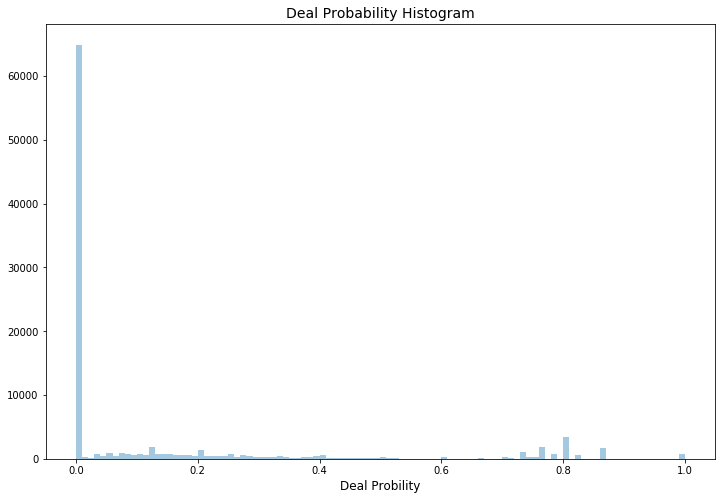

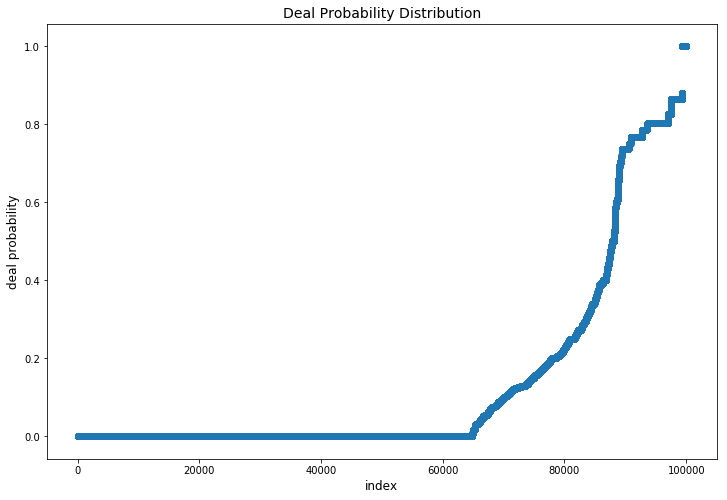

In [44]:
plt.figure(figsize=(12,8))
sns.distplot(training["deal_probability"].values, bins=100, kde=False)
plt.xlabel('Deal Probility', fontsize=12)
plt.title("Deal Probability Histogram", fontsize=14)
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(range(training.shape[0]), np.sort(training['deal_probability'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('deal probability', fontsize=12)
plt.title("Deal Probability Distribution", fontsize=14)
plt.show()

In [46]:
temp_series = training['region'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Region distribution',
    width=900,
    height=900,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="region")

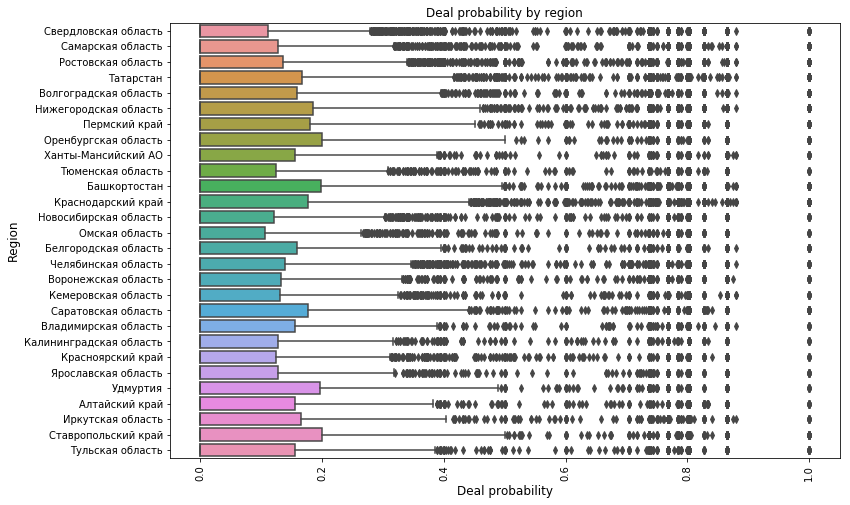

In [47]:
plt.figure(figsize=(12,8))
sns.boxplot(y="region", x="deal_probability", data=training)
plt.xlabel('Deal probability', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.title("Deal probability by region")
plt.xticks(rotation='vertical')
plt.show()